In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pickle
import matplotlib.pyplot as plt
from tabulate import tabulate

In [19]:
test = open('./train_dataset.pickle','rb')
data = np.array(pickle.load(test))
test.close()

In [20]:
test_file = open('./test_dataset.pickle','rb')
test_dataset = np.array(pickle.load(test_file))
test_file.close()
test_performance_set = test_dataset[:, 0]
test_risk_set = test_dataset[:, 1]

In [21]:
n_samples = data.shape[0]
sub_part_size = 20

In [22]:
np.random.shuffle(data)

In [23]:
train_data_subsets = np.array_split(data, sub_part_size)
X_train = data[:, 0]

In [24]:
def GeneratePolynomial(degree):
    poly = PolynomialFeatures(degree=degree)
    poly.fit_transform(X_train.reshape(-1,1))
    return poly

polynomials = [GeneratePolynomial(x) for x in range(1,16)]

In [36]:
def ReturnModel(train_set,poly):
    performance_set =  poly.fit_transform(train_set[:, 0].reshape(-1,1))
    risk_set = train_set[:, 1]
    model = LinearRegression()
    model.fit(performance_set,risk_set)
    return model

models = [[ReturnModel(train_subset,i) for train_subset in train_data_subsets] for i in polynomials]


In [26]:
def find_bias(model_arr):
    def compute(x,model):
        coefs = model.coef_
        intercept = model.intercept_
        ans=intercept
        for i in range(1,coefs.__len__()):
            ans = ans + coefs[i]*( x ** i )
        return ans
    
    def diff(x,y):
        return np.mean([compute(x,model) for model in model_arr]) - y
    return np.mean([ abs(diff(x,y)) for (x,y) in test_dataset])
    
Biases = [find_bias(poly_model) for poly_model in models]

In [27]:
def find_Variance(model_arr):
    def compute(x,model):
        coefs = model.coef_
        intercept = model.intercept_
        ans=intercept
        for i in range(1,coefs.__len__()):
            ans = ans + coefs[i]*( x ** i )
        return ans
    
    def Efx(x):
     return np.mean([compute(x,model) for model in model_arr])
    
    def RetVar(x):
        EFX = Efx(x)
        return np.mean([((compute(x,model) - EFX) ** 2) for model in model_arr])
    
    return np.mean([RetVar(x[0]) for x in test_dataset])

Variance = [find_Variance(poly_model) for poly_model in models]

In [28]:
print(tabulate(np.column_stack((np.arange(1,16),Biases,Variance)),headers=['Degree','Bias', 'Variance']))

# For Report:
# for i in range(1,16):
#     print(i,'\t&',round(Biases[i-1],5),'\t&',round(Variance[i-1],5),'\\\\')

  Degree       Bias     Variance
--------  ---------  -----------
       1  0.270064   0.00520624
       2  0.0869947  0.00126218
       3  0.0333935  0.000402546
       4  0.0247456  0.000504858
       5  0.023561   0.000612374
       6  0.0244987  0.00104047
       7  0.0253529  0.00144852
       8  0.0268157  0.00205437
       9  0.0286975  0.00639609
      10  0.0280811  0.00386193
      11  0.0277972  0.00351772
      12  0.0494646  0.255405
      13  0.0633704  0.70842
      14  0.160615   4.16835
      15  0.0900069  1.83972


In [29]:
def compute_MSE(model_arr):

    def compute(x,model):
        coefs = model.coef_
        intercept = model.intercept_
        ans=intercept
        for i in range(1,coefs.__len__()):
            ans = ans + coefs[i]*( x ** i )
        return ans
    
    def MSE(x,y):
        return np.mean([(y-compute(x,model)) ** 2 for model in model_arr])

    return np.mean([MSE(x,y) for (x,y) in test_dataset])

MSES = np.array([compute_MSE(poly_model) for poly_model in models])

In [30]:
print(tabulate(np.column_stack((np.arange(1,16),MSES)),headers=['Degree', 'MSE']))

  Degree         MSE
--------  ----------
       1  0.119378
       2  0.0133624
       3  0.00510707
       4  0.00476332
       5  0.00481962
       6  0.00522167
       7  0.00566507
       8  0.0064007
       9  0.0109664
      10  0.00824244
      11  0.00792914
      12  0.269707
      13  0.730834
      14  4.52206
      15  1.93783


In [31]:
def compute_Irreducible_error(model_arr):

    def compute(x,model):
        coefs = model.coef_
        intercept = model.intercept_
        ans=intercept
        for i in range(1,coefs.__len__()):
            ans = ans + coefs[i]*( x ** i )
        return ans
    
    def MSE(x,y):
        return np.mean([(y-compute(x,model)) ** 2 for model in model_arr])
    
    def Bias(x,y):
        return np.mean([compute(x,model) for model in model_arr]) - y
    
    def Efx(x):
     return np.mean([compute(x,model) for model in model_arr])
    
    def RetVar(x):
        EFX = Efx(x)
        return np.mean([((compute(x,model) - EFX) ** 2) for model in model_arr])
    
    return np.mean([MSE(x,y) - Bias(x,y) ** 2 - RetVar(x) for (x,y) in test_dataset])

compute_Irreducible_error(models[0])

IRE = [compute_Irreducible_error(poly_arr) for poly_arr in models]

In [32]:
# print(tabulate(np.column_stack((np.arange(1,16),IRE)),headers=['Degree', 'Irreducible Error']))

# For Report
for i in range(1,16):
    print(i,'\t&',IRE[i-1],'\\\\')

1 	& 1.1186798015705435e-17 \\
2 	& -9.174518783572339e-18 \\
3 	& 5.346471963069144e-19 \\
4 	& -1.2487298521601797e-18 \\
5 	& 2.912167035296065e-18 \\
6 	& -3.490724419588642e-18 \\
7 	& 5.972598717679523e-19 \\
8 	& 2.290377089375628e-19 \\
9 	& 2.2979665045830267e-18 \\
10 	& 1.1394964832822651e-18 \\
11 	& 1.8323016715005024e-19 \\
12 	& -3.87122517202243e-17 \\
13 	& 1.0963262632793236e-16 \\
14 	& 3.14822224279504e-16 \\
15 	& 3.124746555255298e-16 \\


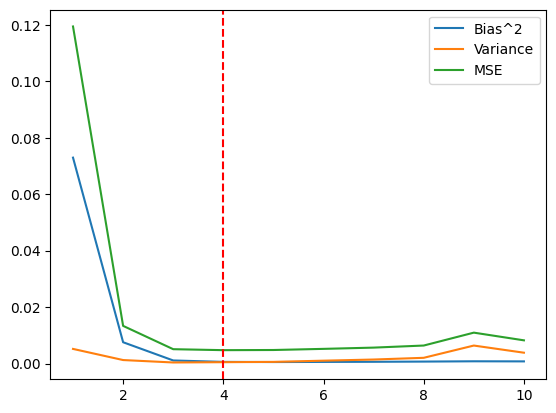

In [33]:
upto = 10
x_plot = [i for i in range(1,upto+1)]
Bias2_plot = [i ** 2 for i in Biases]
plt.plot(x_plot,Bias2_plot[:upto],label='Bias^2')
plt.plot(x_plot,Variance[:upto],label='Variance')
plt.plot(x_plot,MSES[:upto],label='MSE')
plt.axvline(x=MSES.argmin()+1,color='r', linestyle='--')
plt.legend()
plt.show()

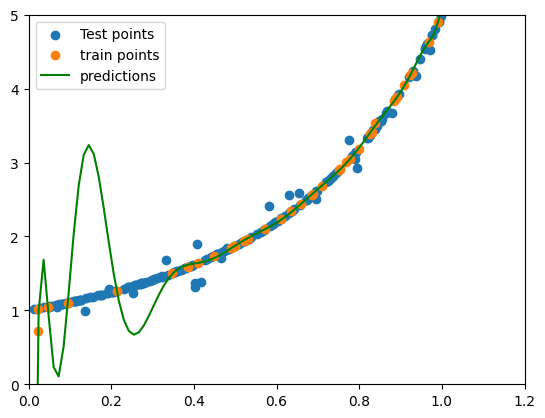

In [34]:
set_number = 0
degree = 15

t = np.linspace(0,1.2,100)
plt.scatter(test_performance_set,test_risk_set,label='Test points')
plt.scatter(train_data_subsets[set_number][:, 0],train_data_subsets[set_number][:, 1],label='train points')
y = models[degree - 1][set_number].predict(polynomials[degree - 1].transform(t.reshape(-1, 1)))
plt.plot(t,y,label='predictions',c='green')
plt.xlim(0,1.2)
plt.ylim(0,5)
plt.legend()
plt.show()